# ANN model Optimization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


columns_to_include = list(range(10))  # This creates a list of integers from 0 to 9
dataset = pd.read_csv('combined_data.csv', delimiter=';', usecols=columns_to_include)

dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], format='%Y/%m/%d %H:%M')

In [2]:
dataset2 = dataset
dataset2.head()

,Timestamp,Module Temperature,Irradiance,Temperature,Humidity,Pressure,Wind Speed,Wind Direction,Rain,PV yield counter
0,2022-09-10 00:00:00,12.500,7.500,13.7,89.0,1001.4,1.4,330.0,0.0,0.0
1,2022-09-10 01:00:00,12.775,7.528,13.0,90.0,1000.8,1.7,350.0,0.0,0.0
2,2022-09-10 02:00:00,12.262,9.034,13.2,92.0,1000.3,1.4,350.0,0.0,0.0
3,2022-09-10 03:00:00,11.972,9.034,10.2,94.0,999.7,1.4,330.0,0.0,0.0
4,2022-09-10 04:00:00,11.810,8.281,10.7,95.0,999.8,1.7,300.0,0.0,0.0


In [3]:
dataset = dataset.iloc[:, 1:]  

X = dataset.iloc[:, :-1].values  
y = dataset.iloc[:, -1].values   

print("Features (X):")
print(X[:5])  
print("Target Variable (y):")
print(y[:5])  

print("Original Shapes - X:", X.shape, "y:", y.shape)

y = np.reshape(y, (-1,1))
print("Reshaped Shapes - X:", X.shape, "y:", y.shape)

Features (X):
[[  12.5      7.5     13.7     89.    1001.4      1.4    330.       0.   ]
 [  12.775    7.528   13.      90.    1000.8      1.7    350.       0.   ]
 [  12.262    9.034   13.2     92.    1000.3      1.4    350.       0.   ]
 [  11.972    9.034   10.2     94.     999.7      1.4    330.       0.   ]
 [  11.81     8.281   10.7     95.     999.8      1.7    300.       0.   ]]
Target Variable (y):
[0. 0. 0. 0. 0.]
Original Shapes - X: (8677, 8) y: (8677,)
Reshaped Shapes - X: (8677, 8) y: (8677, 1)


In [4]:
dataset.head()

,Module Temperature,Irradiance,Temperature,Humidity,Pressure,Wind Speed,Wind Direction,Rain,PV yield counter
0,12.500,7.500,13.7,89.0,1001.4,1.4,330.0,0.0,0.0
1,12.775,7.528,13.0,90.0,1000.8,1.7,350.0,0.0,0.0
2,12.262,9.034,13.2,92.0,1000.3,1.4,350.0,0.0,0.0
3,11.972,9.034,10.2,94.0,999.7,1.4,330.0,0.0,0.0
4,11.810,8.281,10.7,95.0,999.8,1.7,300.0,0.0,0.0


# Splitting and training dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Shape: {} {} \nTest Shape: {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train Shape: (6507, 8) (6507, 1) 
Test Shape: (2170, 8) (2170, 1)


In [6]:

# input scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# outcome scaling:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)    
y_test = sc_y.transform(y_test)

# Creating Neural Network

In [7]:
def create_spfnet(n_layers, n_activation, kernels):
  model = tf.keras.models.Sequential()
  for i, nodes in enumerate(n_layers):
    if i==0:
      model.add(Dense(nodes, kernel_initializer=kernels, activation=n_activation, input_dim=X_train.shape[1]))
      #model.add(Dropout(0.3))
    else:
      model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
      #model.add(Dropout(0.3))
  
  model.add(Dense(1))
  model.compile(loss='mse', 
                optimizer='adam',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

In [8]:
spfnet = create_spfnet([64, 32], 'relu', 'normal')
spfnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


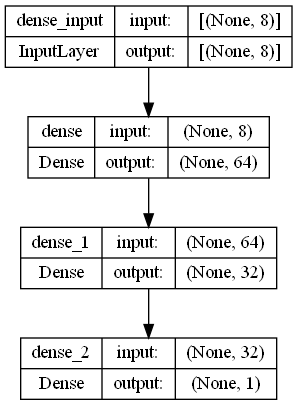

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(spfnet, to_file='spfnet_model.png', show_shapes=True, show_layer_names=True)

In [10]:
spfnet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
for layer in spfnet.layers:
    print(layer.name, layer.output_shape)


dense (None, 64)
dense_1 (None, 32)
dense_2 (None, 1)


In [15]:
hist = spfnet.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test),epochs=500, verbose=2)

Epoch 1/500
204/204 - 4s - loss: 0.2237 - root_mean_squared_error: 0.4730 - val_loss: 0.1114 - val_root_mean_squared_error: 0.3338 - 4s/epoch - 18ms/step
Epoch 2/500
204/204 - 1s - loss: 0.0980 - root_mean_squared_error: 0.3130 - val_loss: 0.1075 - val_root_mean_squared_error: 0.3279 - 798ms/epoch - 4ms/step
Epoch 3/500
204/204 - 1s - loss: 0.0926 - root_mean_squared_error: 0.3044 - val_loss: 0.1057 - val_root_mean_squared_error: 0.3251 - 806ms/epoch - 4ms/step
Epoch 4/500
204/204 - 1s - loss: 0.0915 - root_mean_squared_error: 0.3026 - val_loss: 0.1041 - val_root_mean_squared_error: 0.3227 - 743ms/epoch - 4ms/step
Epoch 5/500
204/204 - 1s - loss: 0.0914 - root_mean_squared_error: 0.3023 - val_loss: 0.1042 - val_root_mean_squared_error: 0.3227 - 811ms/epoch - 4ms/step
Epoch 6/500
204/204 - 1s - loss: 0.0893 - root_mean_squared_error: 0.2989 - val_loss: 0.1025 - val_root_mean_squared_error: 0.3202 - 905ms/epoch - 4ms/step
Epoch 7/500
204/204 - 1s - loss: 0.0894 - root_mean_squared_error:

Epoch 54/500
204/204 - 1s - loss: 0.0710 - root_mean_squared_error: 0.2665 - val_loss: 0.0967 - val_root_mean_squared_error: 0.3109 - 754ms/epoch - 4ms/step
Epoch 55/500
204/204 - 1s - loss: 0.0723 - root_mean_squared_error: 0.2689 - val_loss: 0.0973 - val_root_mean_squared_error: 0.3119 - 857ms/epoch - 4ms/step
Epoch 56/500
204/204 - 1s - loss: 0.0715 - root_mean_squared_error: 0.2674 - val_loss: 0.0952 - val_root_mean_squared_error: 0.3086 - 690ms/epoch - 3ms/step
Epoch 57/500
204/204 - 1s - loss: 0.0711 - root_mean_squared_error: 0.2667 - val_loss: 0.0939 - val_root_mean_squared_error: 0.3064 - 676ms/epoch - 3ms/step
Epoch 58/500
204/204 - 1s - loss: 0.0695 - root_mean_squared_error: 0.2637 - val_loss: 0.0980 - val_root_mean_squared_error: 0.3130 - 714ms/epoch - 4ms/step
Epoch 59/500
204/204 - 1s - loss: 0.0693 - root_mean_squared_error: 0.2633 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3098 - 773ms/epoch - 4ms/step
Epoch 60/500
204/204 - 1s - loss: 0.0708 - root_mean_squar

Epoch 107/500
204/204 - 1s - loss: 0.0628 - root_mean_squared_error: 0.2506 - val_loss: 0.0962 - val_root_mean_squared_error: 0.3102 - 751ms/epoch - 4ms/step
Epoch 108/500
204/204 - 1s - loss: 0.0638 - root_mean_squared_error: 0.2525 - val_loss: 0.0970 - val_root_mean_squared_error: 0.3115 - 860ms/epoch - 4ms/step
Epoch 109/500
204/204 - 1s - loss: 0.0626 - root_mean_squared_error: 0.2502 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3134 - 838ms/epoch - 4ms/step
Epoch 110/500
204/204 - 1s - loss: 0.0635 - root_mean_squared_error: 0.2521 - val_loss: 0.0986 - val_root_mean_squared_error: 0.3140 - 825ms/epoch - 4ms/step
Epoch 111/500
204/204 - 1s - loss: 0.0632 - root_mean_squared_error: 0.2514 - val_loss: 0.0940 - val_root_mean_squared_error: 0.3066 - 849ms/epoch - 4ms/step
Epoch 112/500
204/204 - 1s - loss: 0.0625 - root_mean_squared_error: 0.2500 - val_loss: 0.1006 - val_root_mean_squared_error: 0.3172 - 1s/epoch - 6ms/step
Epoch 113/500
204/204 - 1s - loss: 0.0622 - root_mean_s

Epoch 160/500
204/204 - 1s - loss: 0.0563 - root_mean_squared_error: 0.2373 - val_loss: 0.0954 - val_root_mean_squared_error: 0.3089 - 902ms/epoch - 4ms/step
Epoch 161/500
204/204 - 1s - loss: 0.0557 - root_mean_squared_error: 0.2361 - val_loss: 0.0941 - val_root_mean_squared_error: 0.3067 - 926ms/epoch - 5ms/step
Epoch 162/500
204/204 - 1s - loss: 0.0558 - root_mean_squared_error: 0.2362 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084 - 748ms/epoch - 4ms/step
Epoch 163/500
204/204 - 1s - loss: 0.0560 - root_mean_squared_error: 0.2367 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023 - 786ms/epoch - 4ms/step
Epoch 164/500
204/204 - 1s - loss: 0.0563 - root_mean_squared_error: 0.2372 - val_loss: 0.0995 - val_root_mean_squared_error: 0.3155 - 885ms/epoch - 4ms/step
Epoch 165/500
204/204 - 1s - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.0926 - val_root_mean_squared_error: 0.3044 - 1s/epoch - 6ms/step
Epoch 166/500
204/204 - 1s - loss: 0.0568 - root_mean_s

Epoch 213/500
204/204 - 1s - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3160 - 772ms/epoch - 4ms/step
Epoch 214/500
204/204 - 1s - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3108 - 800ms/epoch - 4ms/step
Epoch 215/500
204/204 - 1s - loss: 0.0508 - root_mean_squared_error: 0.2255 - val_loss: 0.0963 - val_root_mean_squared_error: 0.3104 - 782ms/epoch - 4ms/step
Epoch 216/500
204/204 - 1s - loss: 0.0502 - root_mean_squared_error: 0.2241 - val_loss: 0.0966 - val_root_mean_squared_error: 0.3107 - 787ms/epoch - 4ms/step
Epoch 217/500
204/204 - 1s - loss: 0.0507 - root_mean_squared_error: 0.2251 - val_loss: 0.1038 - val_root_mean_squared_error: 0.3222 - 797ms/epoch - 4ms/step
Epoch 218/500
204/204 - 1s - loss: 0.0507 - root_mean_squared_error: 0.2251 - val_loss: 0.0930 - val_root_mean_squared_error: 0.3050 - 932ms/epoch - 5ms/step
Epoch 219/500
204/204 - 1s - loss: 0.0497 - root_mea

Epoch 266/500
204/204 - 1s - loss: 0.0466 - root_mean_squared_error: 0.2158 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3196 - 798ms/epoch - 4ms/step
Epoch 267/500
204/204 - 1s - loss: 0.0468 - root_mean_squared_error: 0.2162 - val_loss: 0.0977 - val_root_mean_squared_error: 0.3126 - 701ms/epoch - 3ms/step
Epoch 268/500
204/204 - 1s - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.0984 - val_root_mean_squared_error: 0.3137 - 812ms/epoch - 4ms/step
Epoch 269/500
204/204 - 1s - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.0964 - val_root_mean_squared_error: 0.3104 - 746ms/epoch - 4ms/step
Epoch 270/500
204/204 - 1s - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.0992 - val_root_mean_squared_error: 0.3150 - 881ms/epoch - 4ms/step
Epoch 271/500
204/204 - 1s - loss: 0.0467 - root_mean_squared_error: 0.2160 - val_loss: 0.1006 - val_root_mean_squared_error: 0.3172 - 696ms/epoch - 3ms/step
Epoch 272/500
204/204 - 1s - loss: 0.0472 - root_mea

Epoch 319/500
204/204 - 1s - loss: 0.0455 - root_mean_squared_error: 0.2133 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3184 - 790ms/epoch - 4ms/step
Epoch 320/500
204/204 - 1s - loss: 0.0437 - root_mean_squared_error: 0.2090 - val_loss: 0.1044 - val_root_mean_squared_error: 0.3231 - 867ms/epoch - 4ms/step
Epoch 321/500
204/204 - 1s - loss: 0.0429 - root_mean_squared_error: 0.2071 - val_loss: 0.1035 - val_root_mean_squared_error: 0.3218 - 1s/epoch - 6ms/step
Epoch 322/500
204/204 - 1s - loss: 0.0439 - root_mean_squared_error: 0.2095 - val_loss: 0.1029 - val_root_mean_squared_error: 0.3208 - 1s/epoch - 5ms/step
Epoch 323/500
204/204 - 1s - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.1056 - val_root_mean_squared_error: 0.3249 - 1s/epoch - 6ms/step
Epoch 324/500
204/204 - 1s - loss: 0.0434 - root_mean_squared_error: 0.2083 - val_loss: 0.1045 - val_root_mean_squared_error: 0.3232 - 1s/epoch - 5ms/step
Epoch 325/500
204/204 - 2s - loss: 0.0428 - root_mean_squared_er

Epoch 372/500
204/204 - 1s - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.1032 - val_root_mean_squared_error: 0.3212 - 883ms/epoch - 4ms/step
Epoch 373/500
204/204 - 1s - loss: 0.0401 - root_mean_squared_error: 0.2002 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3282 - 1s/epoch - 6ms/step
Epoch 374/500
204/204 - 1s - loss: 0.0414 - root_mean_squared_error: 0.2034 - val_loss: 0.1107 - val_root_mean_squared_error: 0.3327 - 1s/epoch - 7ms/step
Epoch 375/500
204/204 - 1s - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.1074 - val_root_mean_squared_error: 0.3277 - 1s/epoch - 6ms/step
Epoch 376/500
204/204 - 1s - loss: 0.0397 - root_mean_squared_error: 0.1993 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274 - 1s/epoch - 6ms/step
Epoch 377/500
204/204 - 1s - loss: 0.0397 - root_mean_squared_error: 0.1994 - val_loss: 0.1072 - val_root_mean_squared_error: 0.3274 - 1s/epoch - 6ms/step
Epoch 378/500
204/204 - 1s - loss: 0.0400 - root_mean_squared_error

Epoch 425/500
204/204 - 1s - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.1088 - val_root_mean_squared_error: 0.3298 - 1s/epoch - 6ms/step
Epoch 426/500
204/204 - 1s - loss: 0.0372 - root_mean_squared_error: 0.1930 - val_loss: 0.1081 - val_root_mean_squared_error: 0.3288 - 1s/epoch - 7ms/step
Epoch 427/500
204/204 - 1s - loss: 0.0382 - root_mean_squared_error: 0.1956 - val_loss: 0.1087 - val_root_mean_squared_error: 0.3297 - 1s/epoch - 6ms/step
Epoch 428/500
204/204 - 1s - loss: 0.0373 - root_mean_squared_error: 0.1932 - val_loss: 0.1107 - val_root_mean_squared_error: 0.3327 - 1s/epoch - 5ms/step
Epoch 429/500
204/204 - 1s - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.1082 - val_root_mean_squared_error: 0.3289 - 1s/epoch - 5ms/step
Epoch 430/500
204/204 - 1s - loss: 0.0375 - root_mean_squared_error: 0.1938 - val_loss: 0.1091 - val_root_mean_squared_error: 0.3303 - 801ms/epoch - 4ms/step
Epoch 431/500
204/204 - 1s - loss: 0.0378 - root_mean_squared_error

Epoch 478/500
204/204 - 1s - loss: 0.0391 - root_mean_squared_error: 0.1977 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3354 - 860ms/epoch - 4ms/step
Epoch 479/500
204/204 - 1s - loss: 0.0361 - root_mean_squared_error: 0.1900 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397 - 859ms/epoch - 4ms/step
Epoch 480/500
204/204 - 1s - loss: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.1089 - val_root_mean_squared_error: 0.3300 - 846ms/epoch - 4ms/step
Epoch 481/500
204/204 - 1s - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.1111 - val_root_mean_squared_error: 0.3333 - 861ms/epoch - 4ms/step
Epoch 482/500
204/204 - 1s - loss: 0.0362 - root_mean_squared_error: 0.1904 - val_loss: 0.1105 - val_root_mean_squared_error: 0.3324 - 880ms/epoch - 4ms/step
Epoch 483/500
204/204 - 1s - loss: 0.0389 - root_mean_squared_error: 0.1971 - val_loss: 0.1134 - val_root_mean_squared_error: 0.3368 - 748ms/epoch - 4ms/step
Epoch 484/500
204/204 - 1s - loss: 0.0357 - root_mea

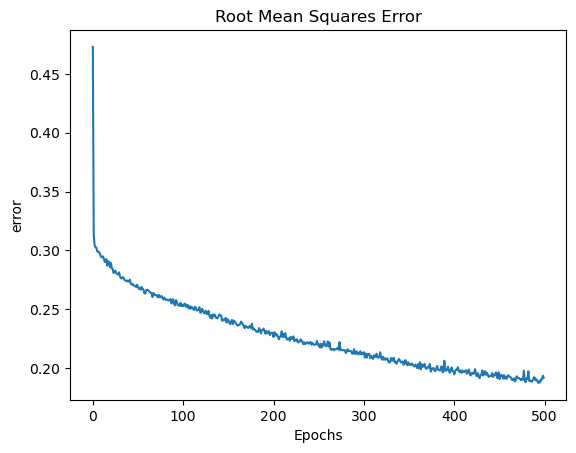

204/204 [==============================] - 1s 3ms/step - loss: 0.0362 - root_mean_squared_error: 0.1904


[0.03623956814408302, 0.1903669238090515]

In [16]:

plt.plot(hist.history['root_mean_squared_error'])
#plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Root Mean Squares Error')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.show()

spfnet.evaluate(X_train, y_train)

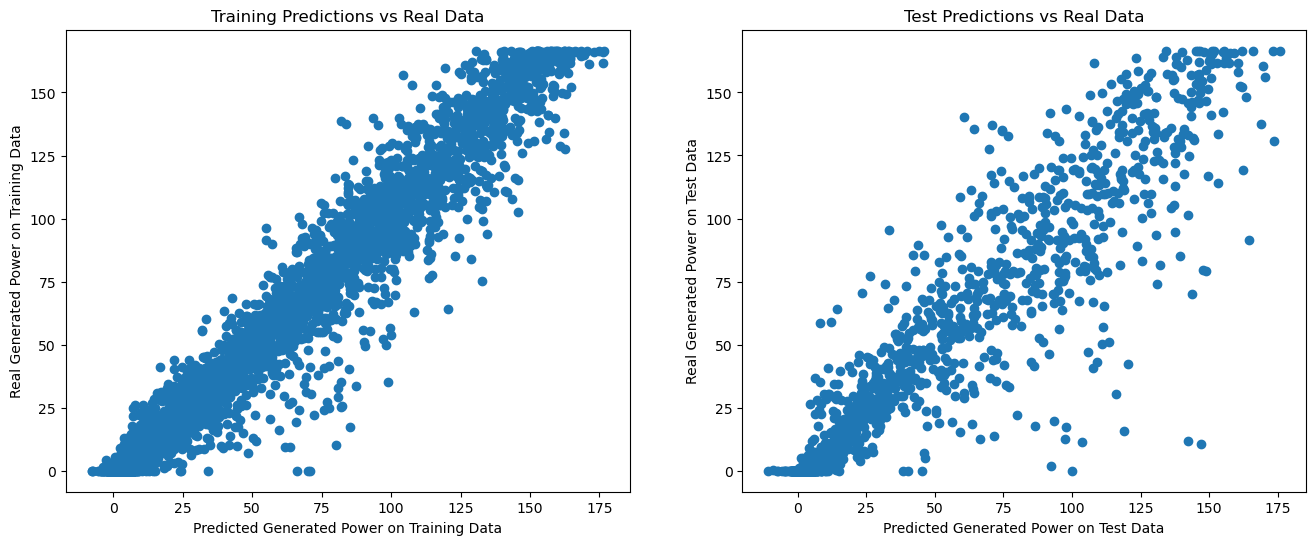

In [23]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
plt.scatter(y_pred_orig, y_test_orig)
plt.xlabel('Predicted Generated Power on Test Data')
plt.ylabel('Real Generated Power on Test Data')
plt.title('Test Predictions vs Real Data')
#plt.scatter(y_test_orig, sc_X.inverse_transform(X_test)[:,2], color='green')
plt.subplot(1,2,1)
plt.scatter(train_pred_orig, y_train_orig)
plt.xlabel('Predicted Generated Power on Training Data')
plt.ylabel('Real Generated Power on Training Data')
plt.title('Training Predictions vs Real Data')
plt.show()

In [24]:
results = np.concatenate((y_test_orig, y_pred_orig), 1)
results = pd.DataFrame(data=results)
results.columns = ['Real Solar Power Produced', 'Predicted Solar Power']
#results = results.sort_values(by=['Real Solar Power Produced'])
pd.options.display.float_format = "{:,.2f}".format
results[800:820]
results[8:18]

,Real Solar Power Produced,Predicted Solar Power
8,140.02,121.88
9,0.00,1.39
10,5.00,5.45
11,152.00,161.93
12,0.00,2.24
13,0.76,4.72
14,0.00,3.68
15,34.87,31.05
16,0.57,3.80
17,0.00,1.55


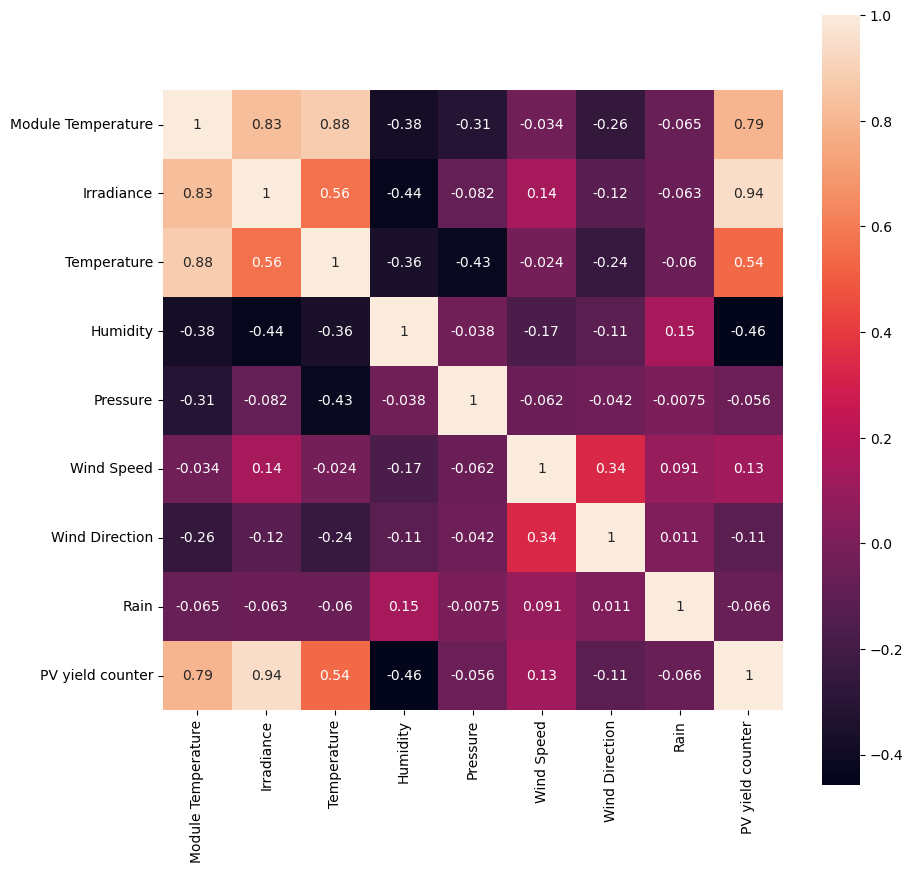

In [29]:
corr = dataset.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, square=True);

In [30]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=dataset.columns[:-1])
lasso_coeff.sort_values('Feature Importance', ascending=False)

,Feature Importance
Irradiance,0.85
Module Temperature,0.14
Pressure,0.03
Wind Direction,0.00
Rain,0.00
Wind Speed,-0.00
Humidity,-0.05
Temperature,-0.06


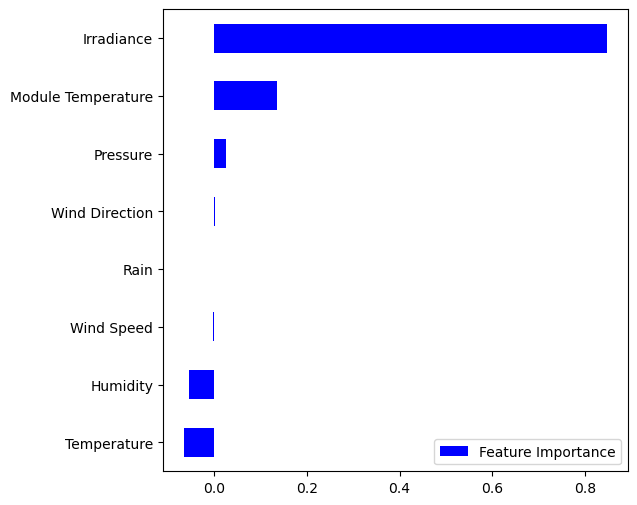

In [31]:
g = lasso_coeff[lasso_coeff['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(6,6), cmap='winter')

TEST METRICS

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_orig, y_pred_orig)

mae = mean_absolute_error(y_test_orig, y_pred_orig)

r2 = r2_score(y_test_orig, y_pred_orig)

rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²) Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)



# this was with 62 32 16
#Mean Squared Error (MSE): 248.44485521196347
#Mean Absolute Error (MAE): 7.741737209978339
#R-squared (R²) Score: 0.8867581357528779
#Root Mean Squared Error (RMSE): 15.762133586921648

# this was with 32 64
#Mean Squared Error (MSE): 239.73126281609373
#Mean Absolute Error (MAE): 8.048090738171744
#R-squared (R²) Score: 0.8907298156910919
#Root Mean Squared Error (RMSE): 15.483257500154602


# with 32 16 8
#Mean Squared Error (MSE): 213.24093810987455
#Mean Absolute Error (MAE): 6.998210905049474
#R-squared (R²) Score: 0.9028041802485086
#Root Mean Squared Error (RMSE): 14.602771590005595

Mean Squared Error (MSE): 231.49915312974866
Mean Absolute Error (MAE): 8.208049546385748
R-squared (R²) Score: 0.8944820344551841
Root Mean Squared Error (RMSE): 15.215096224794264


TRAINING METRICS

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_pred = spfnet.predict(X_train)  # Assuming X_train contains your scaled training features

train_pred_orig = sc_y.inverse_transform(train_pred)

y_train_orig = sc_y.inverse_transform(y_train)

mse_train = mean_squared_error(y_train_orig, train_pred_orig)

mae_train = mean_absolute_error(y_train_orig, train_pred_orig)

r2_train = r2_score(y_train_orig, train_pred_orig)

rmse_train = np.sqrt(mse_train)

print("Training Data Metrics:")
print("Mean Squared Error (MSE):", mse_train)
print("Mean Absolute Error (MAE):", mae_train)
print("R-squared (R²) Score:", r2_train)
print("Root Mean Squared Error (RMSE):", rmse_train)




#Training Data Metrics:
#Mean Squared Error (MSE): 36.3734455887887
#Mean Absolute Error (MAE): 3.2957827446751224
#R-squared (R²) Score: 0.9832365902157816
#Root Mean Squared Error (RMSE): 6.031040174695298

#Training Data Metrics:
#Mean Squared Error (MSE): 86.04063593092027
#Mean Absolute Error (MAE): 5.0308879277922705
#R-squared (R²) Score: 0.9603464996274829
#Root Mean Squared Error (RMSE): 9.275809179307231

# with 32 16 8 
#raining Data Metrics:
#Mean Squared Error (MSE): 158.68597674826466
#Mean Absolute Error (MAE): 6.097963845844798
#R-squared (R²) Score: 0.9268664815174936
#Root Mean Squared Error (RMSE): 12.597062226894995


204/204 [==============================] - 1s 3ms/step
Training Data Metrics:
Mean Squared Error (MSE): 78.63302907475668
Mean Absolute Error (MAE): 5.384041678976196
R-squared (R²) Score: 0.9637604393090327
Root Mean Squared Error (RMSE): 8.86752666050442


# October 2022

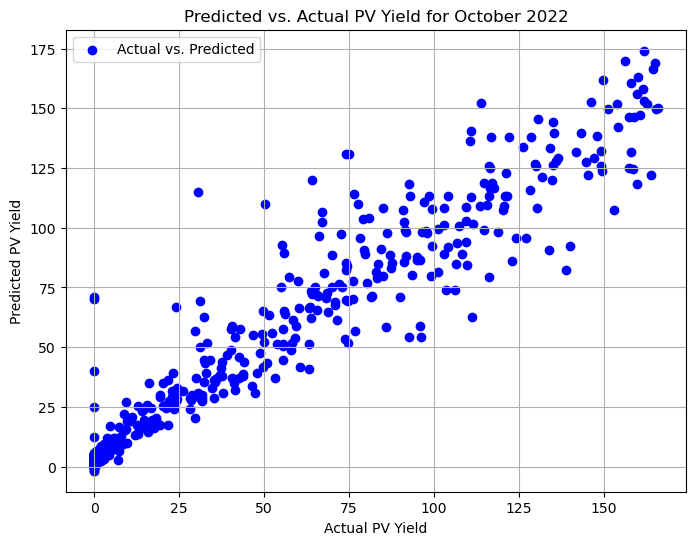

In [34]:
# Filter dataset for October 2022
october_data = dataset2[(dataset2['Timestamp'] >= '2022-10-01') & (dataset2['Timestamp'] <= '2022-10-31')]

october_indices = october_data.index

actual_october_yield = october_data['PV yield counter'].values

predicted_october_yield = pred_whole_orig[october_indices]

# Plotting predicted vs. actual PV yield for October 2022
plt.figure(figsize=(8, 6))
plt.scatter(actual_october_yield, predicted_october_yield, color='b', label='Actual vs. Predicted')
plt.xlabel('Actual PV Yield')
plt.ylabel('Predicted PV Yield')
plt.title('Predicted vs. Actual PV Yield for October 2022')
plt.legend()
plt.grid(True)
plt.show()


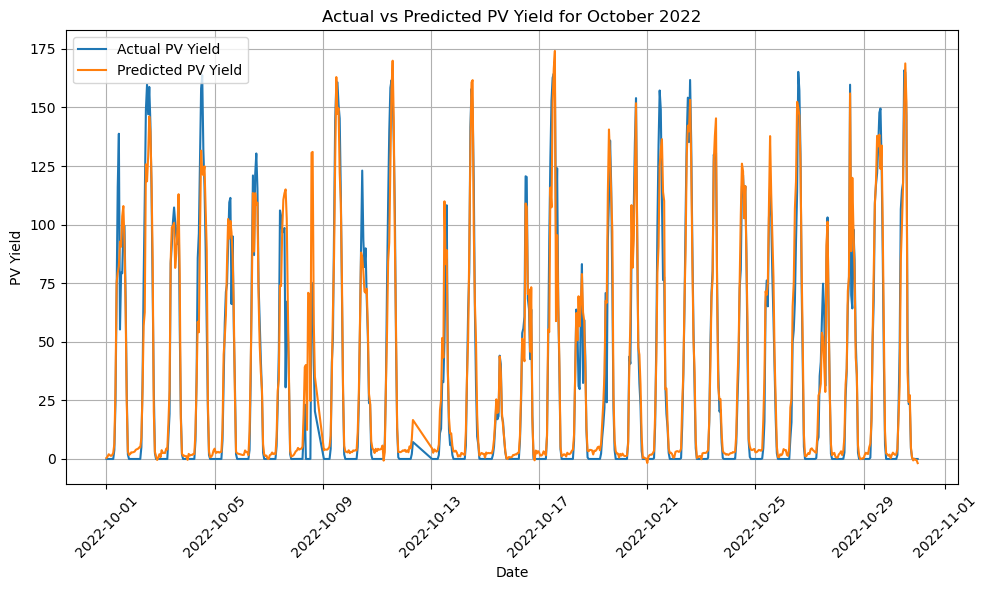

Metrics for October 2022:
Mean Squared Error (MSE): 163.1492327332399
Mean Absolute Error (MAE): 7.299524119589414
R-squared (R²) Score: 0.9300787316450401
Root Mean Squared Error (RMSE): 12.772988402611187
Mean Absolute Percentage Error (MAPE) for October 2022: 5.4837859443675425


In [35]:
# Filter dataset for October 2022
october_data = dataset2[(dataset2['Timestamp'] >= '2022-10-01') & (dataset2['Timestamp'] <= '2022-10-31')]

october_indices = october_data.index

actual_october_yield = october_data['PV yield counter'].values

predicted_october_yield = pred_whole_orig[october_indices]

# Plotting actual vs. predicted PV yield for October 2022 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(october_data['Timestamp'], actual_october_yield, label='Actual PV Yield', )
plt.plot(october_data['Timestamp'], predicted_october_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for October 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_october = mean_squared_error(actual_october_yield, predicted_october_yield)

mae_october = mean_absolute_error(actual_october_yield, predicted_october_yield)

r2_october = r2_score(actual_october_yield, predicted_october_yield)

rmse_october = np.sqrt(mse_october)

print("Metrics for October 2022:")
print("Mean Squared Error (MSE):", mse_october)
print("Mean Absolute Error (MAE):", mae_october)
print("R-squared (R²) Score:", r2_october)
print("Root Mean Squared Error (RMSE):", rmse_october)

average_actual_october_yield = np.mean(actual_october_yield)
average_predicted_october_yield = np.mean(predicted_october_yield)
mape_october = np.abs((average_actual_october_yield - average_predicted_october_yield) / average_actual_october_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for October 2022:", mape_october)


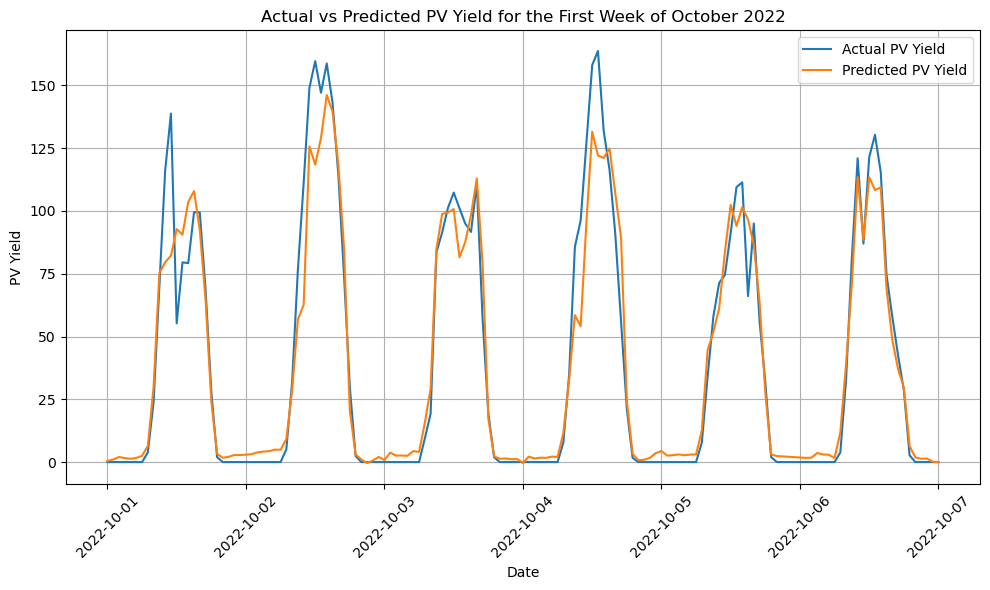

Metrics for the First Week of October 2022:
Mean Squared Error (MSE): 175.19262545146955
Mean Absolute Error (MAE): 7.8750671971997255
R-squared (R²) Score: 0.9313371208825616
Root Mean Squared Error (RMSE): 13.236035110691931
Mean Absolute Percentage Error (MAPE) for the First Week of October 2022: 2.812268067411166


In [36]:
# Filter dataset for the first week of October 2022
first_week_october_data = dataset2[(dataset2['Timestamp'] >= '2022-10-01') & (dataset2['Timestamp'] <= '2022-10-07')]

first_week_october_indices = first_week_october_data.index
actual_first_week_yield = first_week_october_data['PV yield counter'].values

predicted_first_week_yield = pred_whole_orig[first_week_october_indices]

# Plotting actual vs. predicted PV yield for the first week of October 2022 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(first_week_october_data['Timestamp'], actual_first_week_yield, label='Actual PV Yield', )
plt.plot(first_week_october_data['Timestamp'], predicted_first_week_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for the First Week of October 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_week_october = mean_squared_error(actual_first_week_yield, predicted_first_week_yield)

mae_first_week_october = mean_absolute_error(actual_first_week_yield, predicted_first_week_yield)

r2_first_week_october = r2_score(actual_first_week_yield, predicted_first_week_yield)

rmse_first_week_october = np.sqrt(mse_first_week_october)

print("Metrics for the First Week of October 2022:")
print("Mean Squared Error (MSE):", mse_first_week_october)
print("Mean Absolute Error (MAE):", mae_first_week_october)
print("R-squared (R²) Score:", r2_first_week_october)
print("Root Mean Squared Error (RMSE):", rmse_first_week_october)

average_actual_first_week_yield = np.mean(actual_first_week_yield)
average_predicted_first_week_yield = np.mean(predicted_first_week_yield)
mape_first_week_october = np.abs((average_actual_first_week_yield - average_predicted_first_week_yield) / average_actual_first_week_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for the First Week of October 2022:", mape_first_week_october)



1/1 [==============================] - 0s 59ms/step


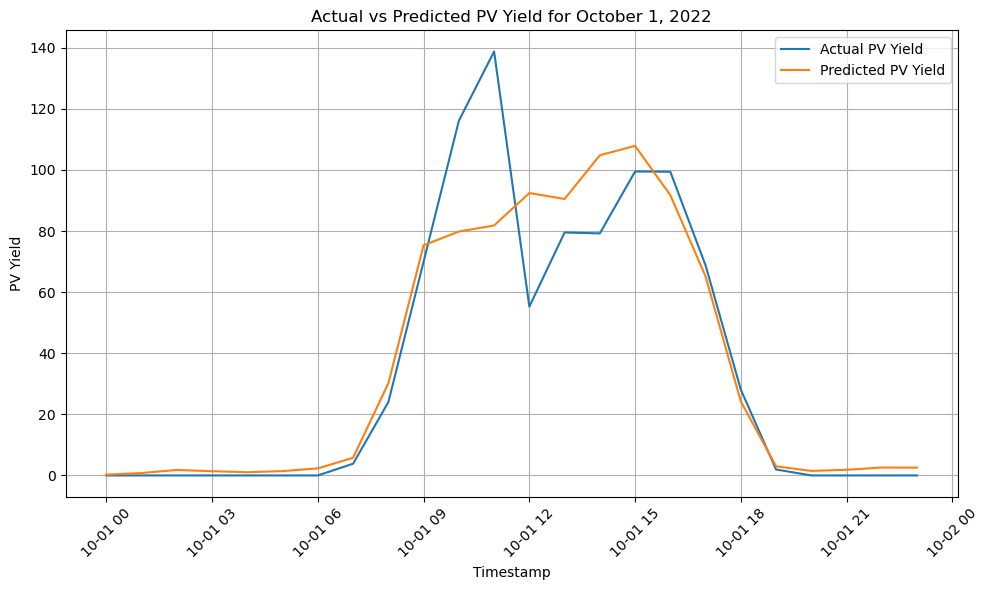

Metrics for October 1, 2022:
Mean Squared Error (MSE): 290.67772595395223
Mean Absolute Error (MAE): 9.26749825919668
R-squared (R²) Score: 0.8548130200864414
Root Mean Squared Error (RMSE): 17.04927347290647
Mean Absolute Percentage Error (MAPE) for October 1, 2022: 0.6648616258372084


In [37]:
# Filter dataset for October 1, 2022
first_day_october_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2022-10-01').date()]

# Extract features (excluding 'Timestamp') and target variable for the first day of October
X_first_day = first_day_october_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day = first_day_october_data['PV yield counter'].values

# Scale features for prediction
X_first_day_scaled = sc_X.transform(X_first_day)

predicted_first_day_yield = spfnet.predict(X_first_day_scaled)
predicted_first_day_yield_orig = sc_y.inverse_transform(predicted_first_day_yield)


# Plotting actual vs. predicted PV yield for the first day of October 2022 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(first_day_october_data['Timestamp'], y_first_day, label='Actual PV Yield')
plt.plot(first_day_october_data['Timestamp'], predicted_first_day_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for October 1, 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_day = mean_squared_error(y_first_day, predicted_first_day_yield_orig)

mae_first_day = mean_absolute_error(y_first_day, predicted_first_day_yield_orig)

r2_first_day = r2_score(y_first_day, predicted_first_day_yield_orig)

rmse_first_day = np.sqrt(mse_first_day)

print("Metrics for October 1, 2022:")
print("Mean Squared Error (MSE):", mse_first_day)
print("Mean Absolute Error (MAE):", mae_first_day)
print("R-squared (R²) Score:", r2_first_day)
print("Root Mean Squared Error (RMSE):", rmse_first_day)

average_actual_first_day_yield = np.mean(y_first_day)
average_predicted_first_day_yield = np.mean(predicted_first_day_yield_orig)
mape_first_day_october = np.abs((average_actual_first_day_yield - average_predicted_first_day_yield) / average_actual_first_day_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for October 1, 2022:", mape_first_day_

DECEMBER 2022

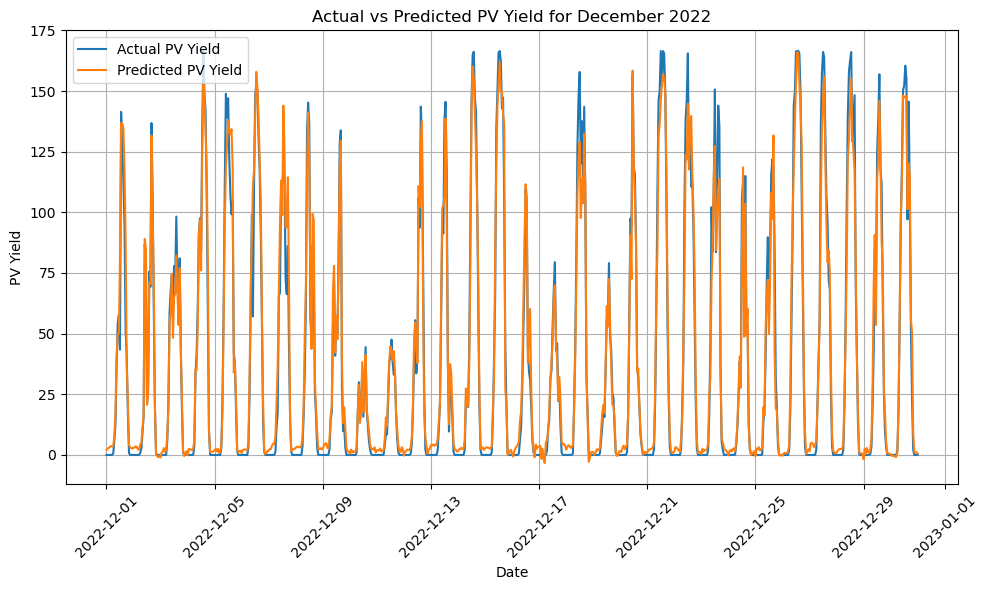

Metrics for December 2022:
Mean Squared Error (MSE): 87.48174836723403
Mean Absolute Error (MAE): 5.897991936994904
R-squared (R²) Score: 0.9672960462335716
Root Mean Squared Error (RMSE): 9.353167825246912
Mean Absolute Percentage Error (MAPE) for December 2022: 1.3666776729898058


In [38]:
# Filter dataset for December 2022
december_data = dataset2[(dataset2['Timestamp'] >= '2022-12-01') & (dataset2['Timestamp'] <= '2022-12-31')]

december_indices = december_data.index

actual_december_yield = december_data['PV yield counter'].values

predicted_december_yield = pred_whole_orig[december_indices]

plt.figure(figsize=(10, 6))
plt.plot(december_data['Timestamp'], actual_december_yield, label='Actual PV Yield', )
plt.plot(december_data['Timestamp'], predicted_december_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for December 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_december = mean_squared_error(actual_december_yield, predicted_december_yield)

mae_december = mean_absolute_error(actual_december_yield, predicted_december_yield)

r2_december = r2_score(actual_december_yield, predicted_december_yield)

rmse_december = np.sqrt(mse_december)

print("Metrics for December 2022:")
print("Mean Squared Error (MSE):", mse_december)
print("Mean Absolute Error (MAE):", mae_december)
print("R-squared (R²) Score:", r2_december)
print("Root Mean Squared Error (RMSE):", rmse_december)

# Calculate Mean Absolute Percentage Error (MAPE) for December 2022
average_actual_december_yield = np.mean(actual_december_yield)
average_predicted_december_yield = np.mean(predicted_december_yield)
mape_december = np.abs((average_actual_december_yield - average_predicted_december_yield) / average_actual_december_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for December 2022:", mape_december)



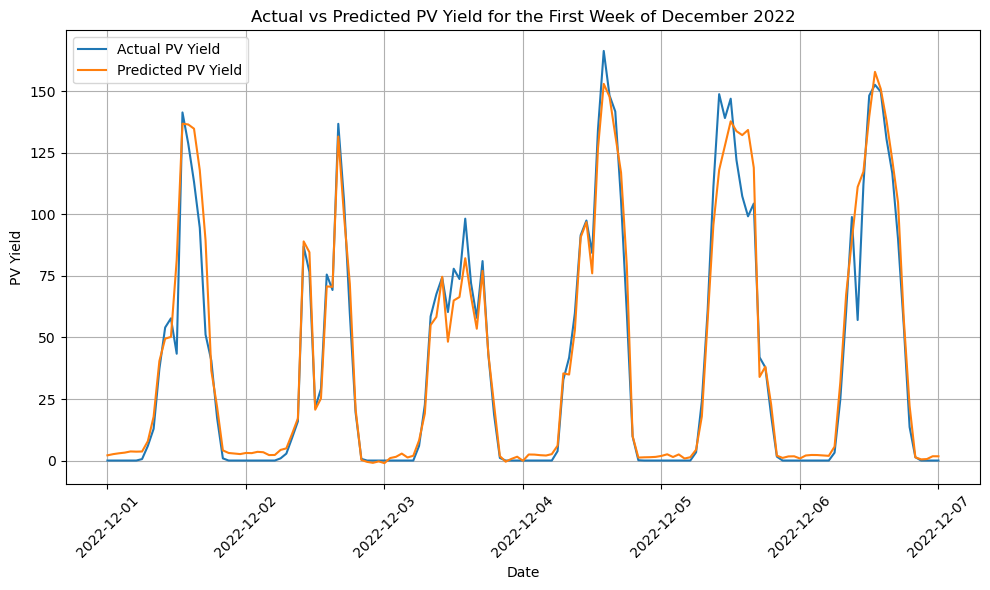

Metrics for the First Week of December 2022:
Mean Squared Error (MSE): 96.260661768053
Mean Absolute Error (MAE): 5.682945078160845
R-squared (R²) Score: 0.9605377477110362
Root Mean Squared Error (RMSE): 9.811251794141917
Mean Absolute Percentage Error (MAPE) for the First Week of December 2022: 4.456691490034424


In [39]:
# Filter dataset for the first week of December 2022
first_week_december_data = dataset2[(dataset2['Timestamp'] >= '2022-12-01') & (dataset2['Timestamp'] <= '2022-12-07')]

# Get the corresponding indices for the first week of December 2022 data
first_week_december_indices = first_week_december_data.index

# Extract actual PV yield values for the first week of December 2022
actual_first_week_december_yield = first_week_december_data['PV yield counter'].values

# Extract predicted PV yield values for the first week of December 2022 using the corresponding indices
predicted_first_week_december_yield = pred_whole_orig[first_week_december_indices]

# Plotting actual vs. predicted PV yield for the first week of December 2022 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(first_week_december_data['Timestamp'], actual_first_week_december_yield, label='Actual PV Yield', )
plt.plot(first_week_december_data['Timestamp'], predicted_first_week_december_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for the First Week of December 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate Mean Squared Error (MSE) for the first week of December 2022
mse_first_week_december = mean_squared_error(actual_first_week_december_yield, predicted_first_week_december_yield)

# Calculate Mean Absolute Error (MAE) for the first week of December 2022
mae_first_week_december = mean_absolute_error(actual_first_week_december_yield, predicted_first_week_december_yield)

# Calculate R-squared (R²) score for the first week of December 2022
r2_first_week_december = r2_score(actual_first_week_december_yield, predicted_first_week_december_yield)

# Calculate Root Mean Squared Error (RMSE) for the first week of December 2022
rmse_first_week_december = np.sqrt(mse_first_week_december)

print("Metrics for the First Week of December 2022:")
print("Mean Squared Error (MSE):", mse_first_week_december)
print("Mean Absolute Error (MAE):", mae_first_week_december)
print("R-squared (R²) Score:", r2_first_week_december)
print("Root Mean Squared Error (RMSE):", rmse_first_week_december)

# Calculate Mean Absolute Percentage Error (MAPE) for the first week of December 2022
average_actual_first_week_december_yield = np.mean(actual_first_week_december_yield)
average_predicted_first_week_december_yield = np.mean(predicted_first_week_december_yield)
mape_first_week_december = np.abs((average_actual_first_week_december_yield - average_predicted_first_week_december_yield) / average_actual_first_week_december_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for the First Week of December 2022:", mape_first_week_december)



1/1 [==============================] - 0s 51ms/step


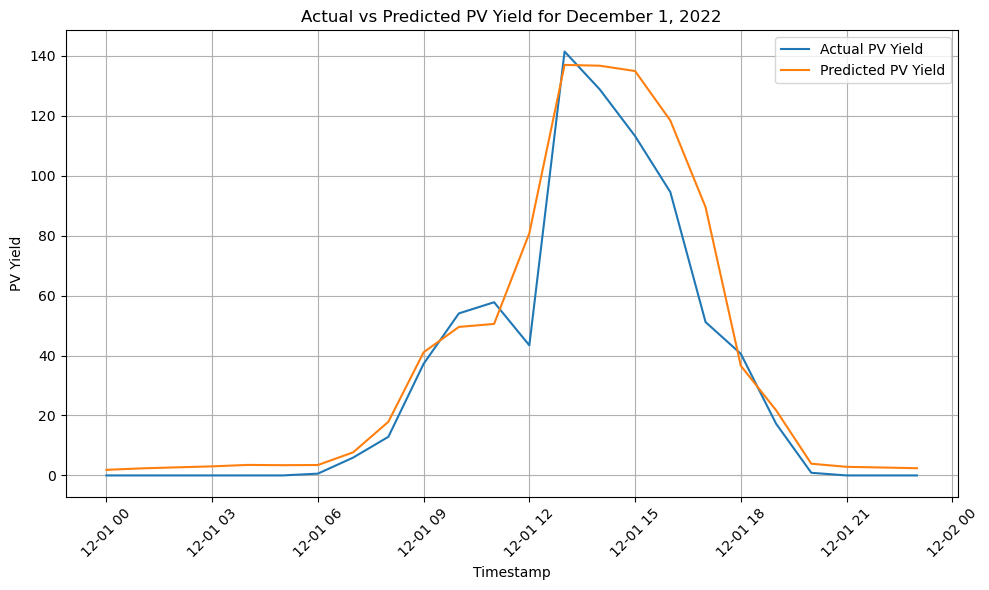

Metrics for December 1, 2022:
Mean Absolute Error (MAE): 8.134387026468913
Mean Squared Error (MSE): 176.3554714815641
Root Mean Squared Error (RMSE): 13.279889739058985
R-squared (R²) Score: 0.9079347011757134
Mean Absolute Percentage Error (MAPE): 19.36159795456346


In [40]:
# Filter dataset for December 1, 2022
first_day_december_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2022-12-01').date()]

X_first_day_december = first_day_december_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day_december = first_day_december_data['PV yield counter'].values

X_first_day_december_scaled = sc_X.transform(X_first_day_december)
predicted_first_day_december_yield = spfnet.predict(X_first_day_december_scaled)
predicted_first_day_december_yield_orig = sc_y.inverse_transform(predicted_first_day_december_yield)

# Plotting actual vs.predicted PV yield for the first day of December 2022 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(first_day_december_data['Timestamp'], y_first_day_december, label='Actual PV Yield')
plt.plot(first_day_december_data['Timestamp'], predicted_first_day_december_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for December 1, 2022')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_day_december = mean_squared_error(y_first_day_december, predicted_first_day_december_yield_orig)

mae_first_day_december = mean_absolute_error(y_first_day_december, predicted_first_day_december_yield_orig)
r2_first_day_december = r2_score(y_first_day_december, predicted_first_day_december_yield_orig)

rmse_first_day_december = np.sqrt(mse_first_day_december)

average_y_first_day_december_actual = np.mean(y_first_day_december)
average_y_first_day_december_pred = np.mean(predicted_first_day_december_yield_orig)
mape_first_day_december = np.abs((average_y_first_day_december_actual - average_y_first_day_december_pred) / average_y_first_day_december_actual) * 100

print("Metrics for December 1, 2022:")
print("Mean Absolute Error (MAE):", mae_first_day_december)
print("Mean Squared Error (MSE):", mse_first_day_december)
print("Root Mean Squared Error (RMSE):", rmse_first_day_december)
print("R-squared (R²) Score:", r2_first_day_december)
print("Mean Absolute Percentage Error (MAPE):", mape_first_day_december)


MARCH 2023

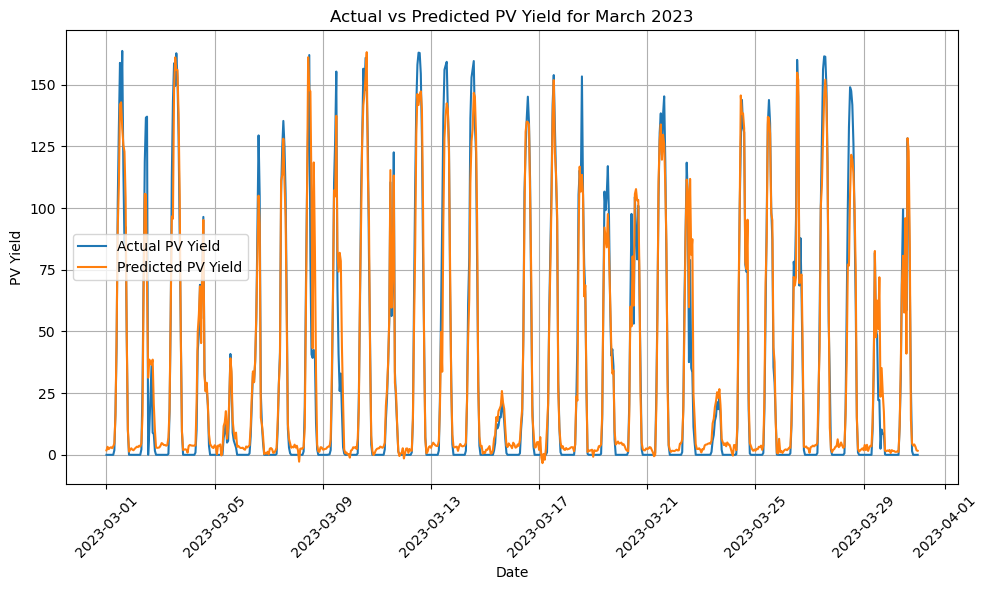

Metrics for March 2023:
Mean Squared Error (MSE): 134.9095742143431
Mean Absolute Error (MAE): 6.492979410577581
R-squared (R²) Score: 0.9443438782278565
Root Mean Squared Error (RMSE): 11.6150580805411
Mean Absolute Percentage Error (MAPE) for March 2023: 3.905445956883264


In [41]:
# Filter dataset for March 2023
march_2023_data = dataset2[(dataset2['Timestamp'] >= '2023-03-01') & (dataset2['Timestamp'] <= '2023-03-31')]

# Get the corresponding indices for March 2023 data
march_2023_indices = march_2023_data.index

# Extract actual PV yield values for March 2023
actual_march_2023_yield = march_2023_data['PV yield counter'].values

# Extract predicted PV yield values for March 2023 using the corresponding indices
predicted_march_2023_yield = pred_whole_orig[march_2023_indices]

# Plotting actual vs. predicted PV yield for March 2023 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(march_2023_data['Timestamp'], actual_march_2023_yield, label='Actual PV Yield', )
plt.plot(march_2023_data['Timestamp'], predicted_march_2023_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for March 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate Mean Squared Error (MSE) for March 2023
mse_march_2023 = mean_squared_error(actual_march_2023_yield, predicted_march_2023_yield)

# Calculate Mean Absolute Error (MAE) for March 2023
mae_march_2023 = mean_absolute_error(actual_march_2023_yield, predicted_march_2023_yield)

# Calculate R-squared (R²) score for March 2023
r2_march_2023 = r2_score(actual_march_2023_yield, predicted_march_2023_yield)

# Calculate Root Mean Squared Error (RMSE) for March 2023
rmse_march_2023 = np.sqrt(mse_march_2023)

print("Metrics for March 2023:")
print("Mean Squared Error (MSE):", mse_march_2023)
print("Mean Absolute Error (MAE):", mae_march_2023)
print("R-squared (R²) Score:", r2_march_2023)
print("Root Mean Squared Error (RMSE):", rmse_march_2023)

# Calculate Mean Absolute Percentage Error (MAPE) for March 2023
average_actual_march_2023_yield = np.mean(actual_march_2023_yield)
average_predicted_march_2023_yield = np.mean(predicted_march_2023_yield)
mape_march_2023 = np.abs((average_actual_march_2023_yield - average_predicted_march_2023_yield) / average_actual_march_2023_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for March 2023:", mape_march_2023)




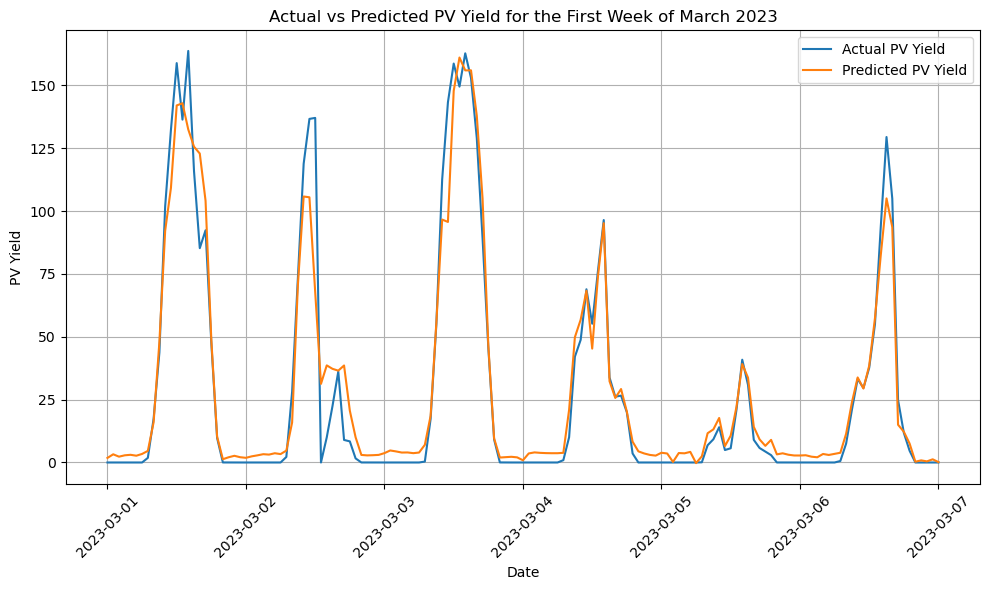

Metrics for the First Week of March 2023:
Mean Squared Error (MSE): 125.54079340894653
Mean Absolute Error (MAE): 6.232371393175783
R-squared (R²) Score: 0.9417939482653781
Root Mean Squared Error (RMSE): 11.204498802219872
Mean Absolute Percentage Error (MAPE) for the First Week of March 2023: 4.098260125218922


In [42]:
# Filter dataset for the first week of March 2023
first_week_march_2023_data = dataset2[(dataset2['Timestamp'] >= '2023-03-01') & (dataset2['Timestamp'] <= '2023-03-07')]

first_week_march_2023_indices = first_week_march_2023_data.index

actual_first_week_march_2023_yield = first_week_march_2023_data['PV yield counter'].values
predicted_first_week_march_2023_yield = pred_whole_orig[first_week_march_2023_indices]

# Plotting actual vs. predicted PV yield for the first week of March 2023 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(first_week_march_2023_data['Timestamp'], actual_first_week_march_2023_yield, label='Actual PV Yield', )
plt.plot(first_week_march_2023_data['Timestamp'], predicted_first_week_march_2023_yield, label='Predicted PV Yield', )
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for the First Week of March 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_week_march_2023 = mean_squared_error(actual_first_week_march_2023_yield, predicted_first_week_march_2023_yield)

mae_first_week_march_2023 = mean_absolute_error(actual_first_week_march_2023_yield, predicted_first_week_march_2023_yield)

r2_first_week_march_2023 = r2_score(actual_first_week_march_2023_yield, predicted_first_week_march_2023_yield)

rmse_first_week_march_2023 = np.sqrt(mse_first_week_march_2023)

print("Metrics for the First Week of March 2023:")
print("Mean Squared Error (MSE):", mse_first_week_march_2023)
print("Mean Absolute Error (MAE):", mae_first_week_march_2023)
print("R-squared (R²) Score:", r2_first_week_march_2023)
print("Root Mean Squared Error (RMSE):", rmse_first_week_march_2023)
average_actual_first_week_march_2023_yield = np.mean(actual_first_week_march_2023_yield)
average_predicted_first_week_march_2023_yield = np.mean(predicted_first_week_march_2023_yield)
mape_first_week_march_2023 = np.abs((average_actual_first_week_march_2023_yield - average_predicted_first_week_march_2023_yield) / average_actual_first_week_march_2023_yield) * 100

print("Mean Absolute Percentage Error (MAPE) for the First Week of March 2023:", mape_first_week_march_2023)



1/1 [==============================] - 0s 41ms/step


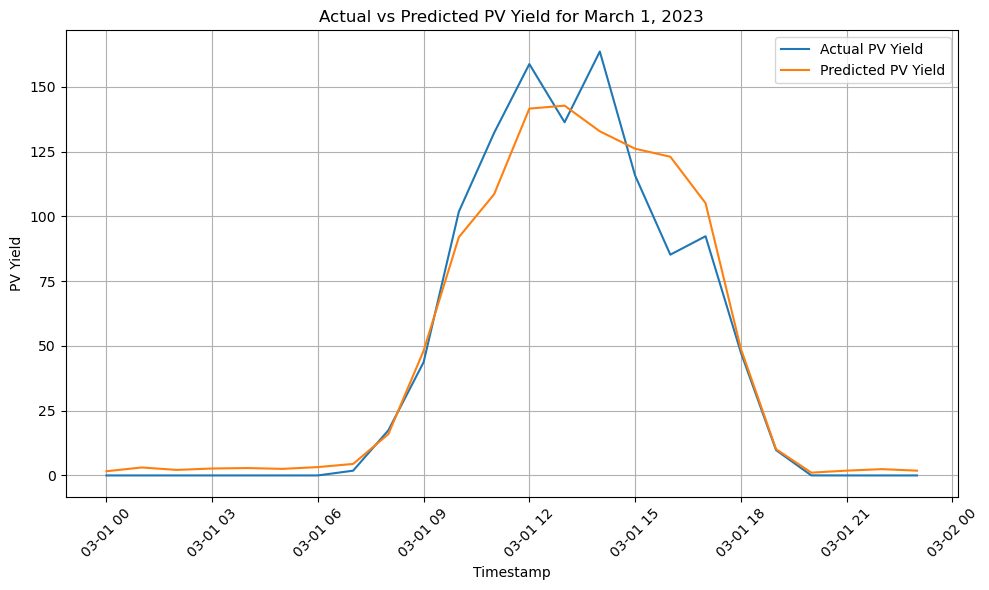

Metrics for March 1, 2023:
Mean Absolute Error (MAE): 7.685460260073344
Mean Squared Error (MSE): 155.6715921887487
Root Mean Squared Error (RMSE): 12.476842236269107
R-squared (R²) Score: 0.9539915764552079
Mean Absolute Percentage Error (MAPE): 1.6653667634170668


In [43]:
# Filter dataset for March 1, 2023
first_day_march_data = dataset2[dataset2['Timestamp'].dt.date == pd.Timestamp('2023-03-01').date()]

# Extract features (excluding 'Timestamp') and target variable for the first day of March 2023
X_first_day_march = first_day_march_data.drop(columns=['Timestamp', 'PV yield counter']).values
y_first_day_march = first_day_march_data['PV yield counter'].values

X_first_day_march_scaled = sc_X.transform(X_first_day_march)

predicted_first_day_march_yield = spfnet.predict(X_first_day_march_scaled)
predicted_first_day_march_yield_orig = sc_y.inverse_transform(predicted_first_day_march_yield)

# Plotting actual vs. predicted PV yield for the first day of March 2023 as a line graph
plt.figure(figsize=(10, 6))
plt.plot(first_day_march_data['Timestamp'], y_first_day_march, label='Actual PV Yield')
plt.plot(first_day_march_data['Timestamp'], predicted_first_day_march_yield_orig, label='Predicted PV Yield')
plt.xlabel('Timestamp')
plt.ylabel('PV Yield')
plt.title('Actual vs Predicted PV Yield for March 1, 2023')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mse_first_day_march = mean_squared_error(y_first_day_march, predicted_first_day_march_yield_orig)

mae_first_day_march = mean_absolute_error(y_first_day_march, predicted_first_day_march_yield_orig)

r2_first_day_march = r2_score(y_first_day_march, predicted_first_day_march_yield_orig)

rmse_first_day_march = np.sqrt(mse_first_day_march)

average_y_first_day_march_actual = np.mean(y_first_day_march)
average_y_first_day_march_pred = np.mean(predicted_first_day_march_yield_orig)
mape_first_day_march = np.abs((average_y_first_day_march_actual - average_y_first_day_march_pred) / average_y_first_day_march_actual) * 100

print("Metrics for March 1, 2023:")
print("Mean Absolute Error (MAE):", mae_first_day_march)
print("Mean Squared Error (MSE):", mse_first_day_march)
print("Root Mean Squared Error (RMSE):", rmse_first_day_march)
print("R-squared (R²) Score:", r2_first_day_march)
print("Mean Absolute Percentage Error (MAPE):", mape_first_day_march)


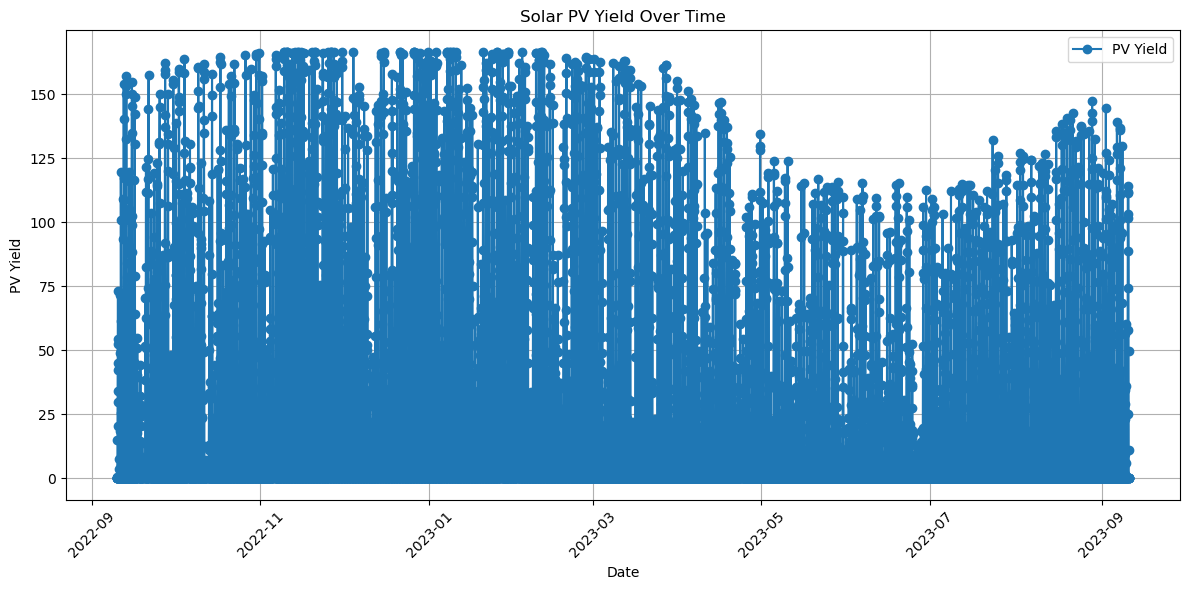

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(dataset2['Timestamp'], dataset2['PV yield counter'], label='PV Yield', marker='o')
plt.xlabel('Date')
plt.ylabel('PV Yield')
plt.title('Solar PV Yield Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


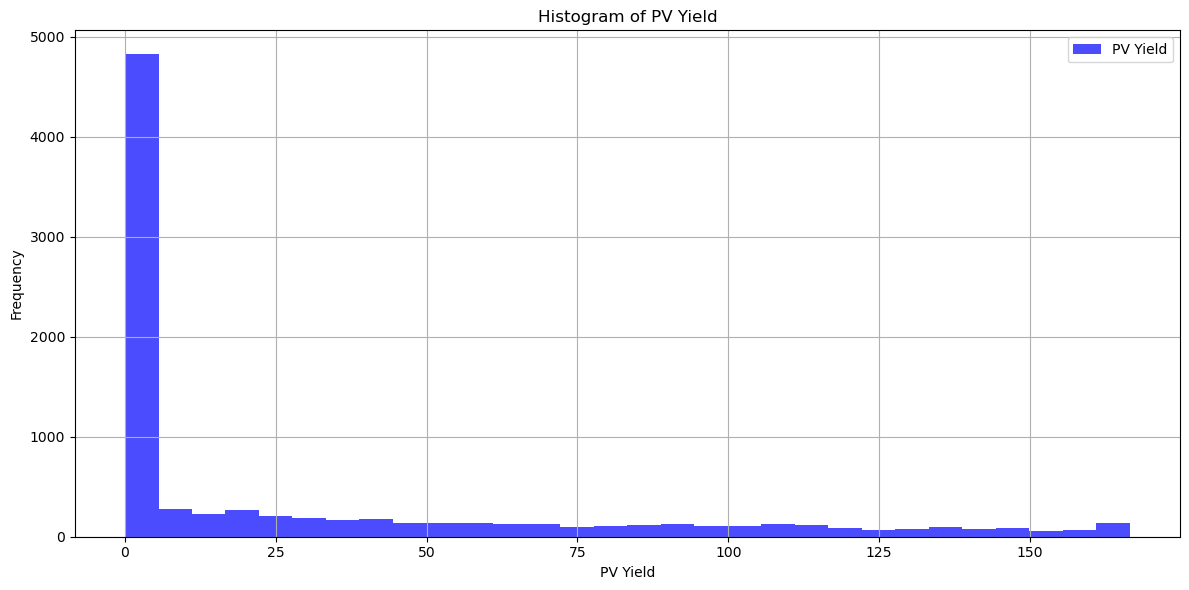

In [45]:
plt.figure(figsize=(12, 6))
plt.hist(dataset2['PV yield counter'], bins=30, alpha=0.7, color='b', label='PV Yield')
plt.xlabel('PV Yield')
plt.ylabel('Frequency')
plt.title('Histogram of PV Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Optimised section

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse_test = mean_squared_error(y_test_orig, y_pred_orig)

# Calculate Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test_orig, y_pred_orig)

# Calculate R-squared (R²) score
r2_test = r2_score(y_test_orig, y_pred_orig)

# Calculate Root Mean Squared Error (RMSE)
rmse_test = np.sqrt(mse_test)

# Calculate Mean Absolute Percentage Error (MAPE)
mape_test = np.abs(np.mean((y_test_orig - y_pred_orig) / y_test_orig)) * 100

df_results = pd.DataFrame.from_dict({
    'R2 Score of Whole Data Frame': r2_score(pred_whole_orig, y),
    'R2 Score of Training Set': r2_score(train_pred_orig, y_train_orig),
    'R2 Score of Test Set': r2_test,
    'Mean Absolute Error (MAE)': mae_test,
    'Mean Squared Error (MSE)': mse_test,
    'Root Mean Squared Error (RMSE)': rmse_test,
    'Mean Absolute Percentage Error (MAPE)': mape_test,
    'Mean of Test Set': np.mean(y_pred_orig),
    'Standard Deviation of Test Set': np.std(y_pred_orig),
    'Relative Standard Deviation': np.std(y_pred_orig) / np.mean(y_pred_orig),
}, orient='index', columns=['Value'])

display(df_results.style.background_gradient(cmap='afmhot', axis=0))


C:\Users\isaac_knss\AppData\Local\Temp\ipykernel_19956\2453879521.py:16: RuntimeWarning: divide by zero encountered in divide
  mape_test = np.abs(np.mean((y_test_orig - y_pred_orig) / y_test_orig)) * 100
C:\Users\isaac_knss\anaconda3\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


,Value
R2 Score of Whole Data Frame,0.939568
R2 Score of Training Set,0.959806
R2 Score of Test Set,0.894482
Mean Absolute Error (MAE),8.208050
Mean Squared Error (MSE),231.499153
Root Mean Squared Error (RMSE),15.215096
Mean Absolute Percentage Error (MAPE),nan
Mean of Test Set,32.384605
Standard Deviation of Test Set,44.668369
Relative Standard Deviation,1.379309


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
def create_model(hidden_layer_size=32):
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Define hyperparameters to search
hidden_layer_sizes = [32, 64, 128]
epochs = [50, 100, 150]
batch_sizes = [32, 64]

best_mse = float('inf')
best_params = {}

# Iterate over hyperparameters and train models
for hidden_size in hidden_layer_sizes:
    for epoch in epochs:
        for batch_size in batch_sizes:
            print(f"Training model with hidden layer size {hidden_size}, epochs {epoch}, batch size {batch_size}")
            model = create_model(hidden_layer_size=hidden_size)
            model.fit(X_train_scaled, y_train, epochs=epoch, batch_size=batch_size, verbose=0)
            y_pred = model.predict(X_test_scaled)
            mse = mean_squared_error(y_test, y_pred)
            print(f"Mean Squared Error: {mse}")
            if mse < best_mse:
                best_mse = mse
                best_params = {'hidden_layer_size': hidden_size, 'epochs': epoch, 'batch_size': batch_size}

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_mse)


Training model with hidden layer size 32, epochs 50, batch size 32
68/68 [==============================] - 0s 2ms/step
Mean Squared Error: 0.10253842195673768
Training model with hidden layer size 32, epochs 50, batch size 64
68/68 [==============================] - 0s 2ms/step
Mean Squared Error: 0.10306124581775211
Training model with hidden layer size 32, epochs 100, batch size 32
68/68 [==============================] - 0s 2ms/step
Mean Squared Error: 0.10209791365971059
Training model with hidden layer size 32, epochs 100, batch size 64
68/68 [==============================] - 0s 4ms/step
Mean Squared Error: 0.09923980218461669
Training model with hidden layer size 32, epochs 150, batch size 32
68/68 [==============================] - 0s 3ms/step
Mean Squared Error: 0.10096982231724462
Training model with hidden layer size 32, epochs 150, batch size 64
68/68 [==============================] - 0s 2ms/step
Mean Squared Error: 0.1013579071074011
Training model with hidden layer size

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_mse = float('inf')  # Initialize best mean squared error
best_model = None  # Initialize the best model

# Define hyperparameters to search
hidden_layers_list = [1, 2, 3]
hidden_units_list = [32, 64, 128]

# Perform manual hyperparameter search
for hidden_layers in hidden_layers_list:
    for hidden_units in hidden_units_list:
        # Build the neural network model
        model = Sequential()
        model.add(Dense(hidden_units, input_dim=X_train.shape[1], activation='relu'))
        for _ in range(hidden_layers - 1):
            model.add(Dense(hidden_units, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)

        # Calculate mean squared error
        mse = mean_squared_error(y_test, y_pred)

        # Update the best model if the current model is better
        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_hidden_layers = hidden_layers
            best_hidden_units = hidden_units

# Print the best hyperparameters and corresponding mean squared error
print("Best Number of Hidden Layers:", best_hidden_layers)
print("Best Number of Hidden Units:", best_hidden_units)
print("Best Mean Squared Error:", best_mse)

# Now 'best_model' contains the neural network with the best hyperparameters


68/68 [==============================] - 1s 5ms/step
Best Number of Hidden Layers: 2
Best Number of Hidden Units: 64
Best Mean Squared Error: 0.09584883809566348
